# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from scipy.stats import pearsonr
from talib import RSI, BBANDS, MACD, ATR

In [2]:
MONTH = 21
YEAR = 12 * MONTH

In [3]:
START = '2010-01-01'
END = '2017-12-31'

In [4]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [5]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [6]:
T = [1, 5, 10, 21, 42, 63]

## Loading Quandl Wiki Stock Prices & Meta Data

In [7]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])

In [8]:
prices.volume /= 1e3
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations

In [9]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [10]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [11]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

### Limit universe to 1,000 stocks with highest market cap

In [12]:
universe = metadata.marketcap.nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [13]:
metadata.sector.value_counts()

consumer_services        187
finance                  168
technology               116
health_care              103
capital_goods             94
basic_industries          67
public_utilities          66
consumer_non-durables     61
energy                    51
consumer_durables         36
miscellaneous             28
transportation            23
Name: sector, dtype: int64

In [14]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, (A, 2010-01-04 00:00:00) to (ZION, 2017-12-29 00:00:00)
Data columns (total 5 columns):
open      2004775 non-null float64
close     2004775 non-null float64
low       2004775 non-null float64
high      2004775 non-null float64
volume    2004775 non-null float64
dtypes: float64(5)
memory usage: 84.3+ MB


In [15]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, AAPL to NTCT
Data columns (total 2 columns):
marketcap    1000 non-null float64
sector       1000 non-null object
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


### Compute Rolling Average Dollar Volume

In [16]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices.loc[:, 'close'].mul(prices.loc[:, 'volume'], axis=0).div(1e3)
prices['dollar_vol'] = (prices
                        .groupby('symbol',
                                 group_keys=False,
                                 as_index=False)
                        .dollar_vol
                        .rolling(window=21)
                        .mean()
                        .fillna(0)
                        .reset_index(level=0, drop=True))

In [17]:
prices['dollar_vol_rank'] = (prices
                             .groupby('date')
                             .dollar_vol
                             .rank(ascending=False))
prices = prices.drop('dollar_vol', axis=1)

## Add some Basic Factors

### Compute the Relative Strength Index

In [18]:
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI)

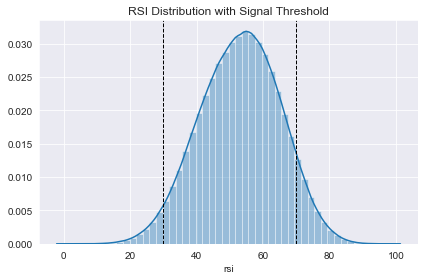

In [19]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [20]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [21]:
prices = (prices.join(prices
                      .groupby(level='symbol')
                      .close
                      .apply(compute_bb)))

In [22]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

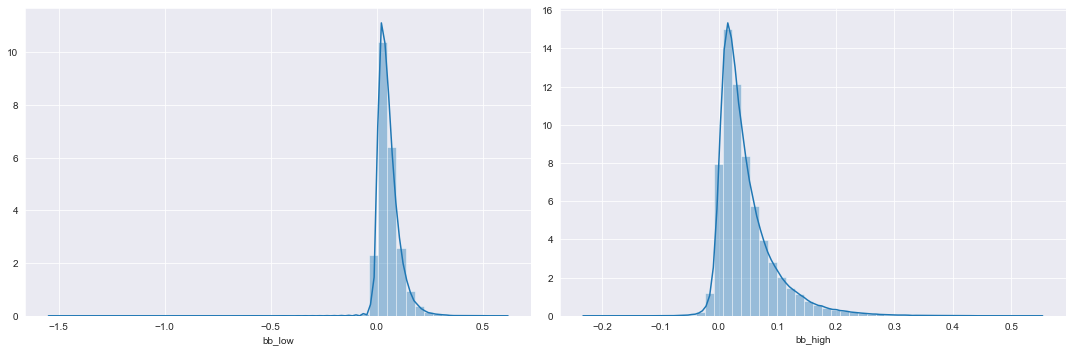

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [24]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [25]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [26]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [27]:
prices['PPO'] = prices.groupby(level='symbol').close.apply(talib.PPO)

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [29]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [30]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns

### Historical Returns

In [31]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

### Daily historical return quantiles

In [33]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}'].groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')))

### Daily sector return quantiles

In [35]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices.groupby(
        ['date', 'sector'])[f'r{t:02}'].transform(
            lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop')))

### Compute Forward Returns

In [36]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers

In [37]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,2.003775e+06,1.999775e+06,1.994775e+06,1.983775e+06,1.962775e+06,1.941775e+06
mean,7.519751e-04,3.726962e-03,7.353932e-03,1.555927e-02,3.113691e-02,4.619119e-02
std,2.166262e-02,4.791746e-02,6.579895e-02,9.467552e-02,1.325751e-01,1.618423e-01
min,-8.757416e-01,-8.768476e-01,-8.778415e-01,-8.802285e-01,-8.867366e-01,-8.863481e-01
25%,-8.088407e-03,-1.721664e-02,-2.291896e-02,-3.045918e-02,-3.531712e-02,-3.696833e-02
50%,6.561680e-04,3.702235e-03,7.173181e-03,1.503253e-02,2.899023e-02,4.217809e-02
75%,9.509191e-03,2.440601e-02,3.707177e-02,5.927618e-02,9.305628e-02,1.219666e-01
max,1.216425e+01,1.252657e+01,1.252657e+01,1.252657e+01,1.181643e+01,1.166968e+01


In [38]:
outliers = prices[prices.r01>1].index.get_level_values('symbol').unique()

In [39]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables

In [40]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [55]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1994931 entries, (A, 2010-01-04 00:00:00) to (ZION, 2017-12-29 00:00:00)
Data columns (total 38 columns):
open               1994931 non-null float64
close              1994931 non-null float64
low                1994931 non-null float64
high               1994931 non-null float64
volume             1994931 non-null float64
dollar_vol_rank    1994931 non-null float64
rsi                1981001 non-null float64
bb_high            1976026 non-null float64
bb_low             1976022 non-null float64
NATR               1981001 non-null float64
ATR                1981001 non-null float64
PPO                1970056 non-null float64
MACD               1962096 non-null float64
sector             1994931 non-null int64
r01                1993936 non-null float64
r05                1989956 non-null float64
r10                1984981 non-null float64
r21                1974036 non-null float64
r42                1953141 non-null float64
r63       

In [54]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data/data.h5', 'model_data')